In [3]:
import numpy as np
import networkx as nx

In [4]:
# gen_initial_perm: Genera una permutacion inicial
# Dada una matriz de adyacencia A, genera la permutacion de vertices sigma, donde
# sigma es la permutacion donde los nodos estan en orden decreciente segun su grado
def gen_initial_perm(A):
    #grados = np.zeros(A.shape[0])
    grados = np.apply_along_axis(sum, 1, A)
    
    return np.flip(np.argsort(grados)) #argsort retorna los indices que ordenan la lista, justo lo que queremos 

In [5]:
#Se genera un grafo aleatorio para testear el algoritmo

G = nx.fast_gnp_random_graph(50,0.4)
L = nx.adjacency_matrix(G).todense()
s = gen_initial_perm(L)
dict_t = {}
for i in range(s.size):
    dict_t[s[i]] = str(i)

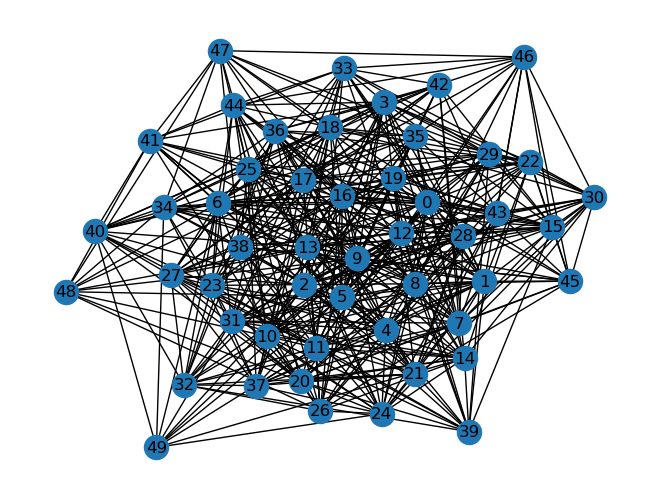

In [14]:
#Se dibujo el grafos
nx.draw(G, labels=dict_t)

In [15]:
# graph_clique : Dibujo el grafo dado y resalta el m-clique dado
# G es el grafo, m es el tamano del clique, sigma es la permutacion de los nodos donde
# sus primeras m entradas son las entradas del clique}
# se advierte que esta funcion solo dibuja, no revisa si efectivamente existe el clique
def graph_clique(G,m,sigma):
    pos = nx.spring_layout(G)
    #print(sigma_lol)
    nodes = {
        'r': sigma[0:m],
        'b': sigma[m:]
    }
    aristas = []
    for i in range(m-1):
        for j in range(i,m):
            aristas.append( (sigma[i],sigma[j]) )

    for node_color, nodelist in nodes.items():
        nx.draw_networkx_nodes(G, pos, nodelist=nodelist, node_color=node_color, node_size = 25)

    labels = {x: x for x in G.nodes}
    #nx.draw_networkx_labels(G, pos, labels, font_size='0', font_color='w')
    nx.draw_networkx_edges(G,pos,width=1.0,alpha=0.5)
    nx.draw_networkx_edges(G,pos,
                           edgelist=aristas,
                           width=1.5,alpha=0.8,edge_color='r')

# Primera implementación del SA para m-clique

In [9]:
# F : Funcion objetivo a minimizar
# A es matriz de adyacencia, sigma es una permutacion de los nodos, m es el tamano del clique
def F(A, sigma,m):
    h = 0
    for k in range(m-1):
        for l in range(k+1,m):
            h += 1 - A[sigma[k],sigma[l]]
    return h

# F_prima : Funcion auxiliar usada para encontrar vecino
# A es matriz de adyacencia, z es algun indice de algun nodo, m el tamano del clique
def F_prima(z,A,m):
    l = 0
    for i in range(m):
        if i == z: continue
        
        l += A[i,z]
    
    return l
    
# vecino:
# Dada una permutacion, entregua un vecino el cual se obtiene siguiendo las reglas del paper
# m es el numero del clique que se busca, A es matriz de adyacencia
def vecino(sigma,m,A):
    n = A.shape[0]
    new_sig = sigma.copy()
    
    u = np.random.randint(0,m)
    w = np.random.randint(m,n)
    contador = 0
    
    #Restricting Condition

    while F_prima(u,A,m) > F_prima(w,A,m):
        contador += 1
        if contador >= 8*n: # se acepta de todas formas
            break
            
        w = np.random.randint(m,n)
    
    new_sig[u] = sigma[w]
    new_sig[w] = sigma[u]
    
    return new_sig

In [10]:
#Decision_SA : Resuelve el problema de decision de m-clique con SA
# m es el tamano del clique, steps es la cantidad maxima de pasos que SA realiza
# A es la matriz de adyacencia del grafo, beta funcion de temperatura
def Decision_SA(m,steps,A,beta):
    sigma = gen_initial_perm(A)
    cost = F(A,sigma,m)
    
    for n in range(steps):
        
        u = np.random.uniform(0, 1)
        sigma_new = vecino(sigma,m,A)
        cost_new =  F(A,sigma_new,m)
        
        if cost_new == 0:
            sigma = sigma_new
            break
        else:
            cte = min(1.0, np.exp(-beta(n) * (cost_new - cost)))
            
            if u <= cte:
                sigma = sigma_new
                
    return (sigma_new, n)

## Probando el algoritmo

In [22]:
def beta_lol(n):
    return (n/50000)**2

sigma_lol, n_lol = Decision_SA(6,1000000,L,beta_lol)
print(n_lol)

127383


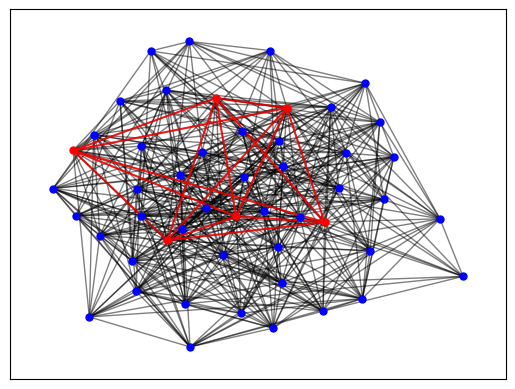

In [31]:
graph_clique(G,6,sigma_lol)

In [32]:
#Clique encontrado por SA
print(sigma_lol[0:6])

[ 6 30 32  4 33 37]


In [29]:
#Clique aproximado por el algoritmo de aproximacion 
nx.approximation.max_clique(G)

{0, 1, 14, 16, 33, 45}

In [33]:
#Clique encontrado por el algoritmo exacto
for node in G.nodes():
    G.nodes[node]['weight'] = 1

nx.algorithms.max_weight_clique(G)

([12, 39, 10, 6, 29, 17], 6)

## Leyendo grafos de DIMAC 

In [34]:
# read_DIMAC: recibe como input la direccion de un archivo de un grafo dimac en formato ascii
# y entrega un grafo de NetworkX que corresponde al grafo del archivo
def read_DIMAC(archivo):
    edges_d = []

    with open(archivo) as f:
        lines = f.readlines()

    for line in lines:
        if line[0] != 'e':
            continue

        edges_tmp = line[2:].strip().split() 
        for i in range(2):
            edges_tmp[i] =  int(edges_tmp[i]) - 1
        
        edges_d.append(edges_tmp )

    g = nx.Graph()
    g.add_edges_from(edges_d)

    return g

In [37]:
#Leyendo C125.9
H = read_DIMAC("dimacs_graphs/C125.9.clq")

for node in H.nodes():
    H.nodes[node]['weight'] = 1

In [38]:
sigma_lol, n_lol = Decision_SA(17,100000,nx.adjacency_matrix(H).todense(),beta_lol)
print(n_lol)

99999


In [40]:
nx.algorithms.max_weight_clique(H)

([82,
  67,
  92,
  70,
  121,
  120,
  116,
  78,
  43,
  114,
  30,
  4,
  0,
  47,
  24,
  8,
  1,
  122,
  76,
  33,
  69,
  17,
  48,
  84,
  28,
  10,
  109,
  100,
  81,
  79,
  6,
  113,
  59,
  53],
 34)

## Generando estadisticas

In [41]:
# get_estadisticas_decision : 
# Dado un grafo, ejecuta el SA, retornando un vector del numero de pasos que se demoro en terminar
# si es que termino de manera exitosa
def get_estadisticas_decision(A,m,max_step,beta,times):
    contador = 0
    v = np.zeros(times)
    while contador < times:
        sigma, n = Decision_SA(m,max_step,A,beta)
        if n == max_step-1:
            continue
        
        v[contador] = n
        
        contador += 1
    return v

In [43]:
# Definiendo temperaturas exponenciales y cuadraticas para comparar
beta_1 = lambda x : (x/10000)**2
beta_2 = lambda x : np.exp(x/10000)

In [44]:
lol = get_estadisticas_decision(L,5,int(1e5),beta_1,100)
print(lol.mean())
print(lol.std())
lol = get_estadisticas_decision(L,5,int(1e5),beta_2,100)
print(lol.mean())
print(lol.std())

6470.97
4018.8882255046606
2581.33
2247.741724731736


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=0c9976c5-9f49-4505-a462-6037475512d7' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>